In [1]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A
import requests

from io import BytesIO

from PIL import Image

import random
import torch

from tqdm.notebook import tqdm

import torch.nn as nn

import torch.optim as optim

import torch.autograd.grad_mode as grad_mode

from torch.autograd import Function as F

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torchvision.models.detection.rpn import AnchorGenerator

from torchvision import transforms as torchtrans

import os

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
def imgshow(number, title=None, size=5):
    root = "/kaggle/input/guns-object-detection/"
    
    # Read the image using OpenCV
    image_path = root + "Images/" + str(number) + ".jpeg"
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image not found at {image_path}")
        return

    # Read the label file
    label_path = root + "Labels/" + str(number) + ".txt"
    try:
        with open(label_path, "r") as file:
            txt_data = file.readlines()  # <- CORRECTED: should be readlines(), not readLines()
    except FileNotFoundError:
        print(f"Label file not found at {label_path}")
        return

    # Draw bounding boxes
    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].strip().split()]  # .strip() removes newlines
        start_point = (indices[0], indices[1])
        end_point = (indices[2], indices[3])
        cv2.rectangle(image, start_point, end_point, (0, 0, 255), 2)

    # Display the image with bounding boxes
    aspect_ratio = image.shape[0] / image.shape[1]
    plt.figure(figsize=(size + aspect_ratio, size))

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # If title is provided, append box count
    if title:
        plt.title(title + ": " + txt_data[0].strip())
    else:
        plt.title("Bounding Boxes: " + txt_data[0].strip())
        
    plt.axis('off')
    plt.show()


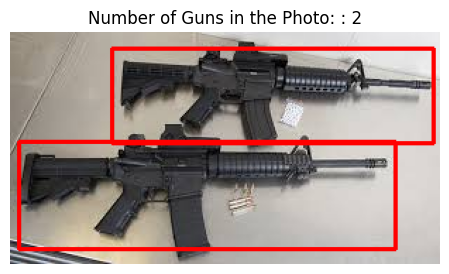

In [5]:
imgshow(119, title="Number of Guns in the Photo: ")

In [6]:
class Gun_Data(Dataset):

    def __init__(self, root):
        self.image_path = root + "Images/"
        self.label_path = root + "Labels/"

        self.img_name = sorted(os.listdir(self.image_path))
        self.label_name = sorted(os.listdir(self.label_path))


    def __getitem__(self, idx):
        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).permute(2, 0, 1)

        label_name = self.img_name[idx][:-4] + "txt"
        label_path =  os.path.join(self.label_path, str(label_name))

        with open(label_path,"r") as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target = {}
        area = []
        labels = []

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)

        return img_res, target

    def __len__(self):
        return len(self.img_name)
                



In [7]:
class Model:
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)

        in_features = model.roi_heads.box_predictor.cls_score.in_features

        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)

        return model

    def compiler( self, optimizer):
        self.optimizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)

            train_loss = 0
            self.model.train()

            for img, target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())

                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                train_loss += loss.item()

            print(f"Epoch : {epoch+1} | Train loss: {train_loss}")



In [8]:
rcnn = Model(2)

model = rcnn.model

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 30

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Gun_Data("/kaggle/input/guns-object-detection/")

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn= collate_fn)

val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn= collate_fn)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 79.9MB/s] 


In [9]:
rcnn.train(train_loader, val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 1 | Train loss: 24.468342013657093
Epoch : 2 | Train loss: 18.30673272907734
Epoch : 3 | Train loss: 16.09504173696041
Epoch : 4 | Train loss: 13.618801422417164
Epoch : 5 | Train loss: 11.70909272134304
Epoch : 6 | Train loss: 9.995136722922325
Epoch : 7 | Train loss: 11.094549659639597
Epoch : 8 | Train loss: 9.195745885372162
Epoch : 9 | Train loss: 7.106409274041653
Epoch : 12 | Train loss: 5.700047627091408
Epoch : 13 | Train loss: 4.99063191190362
Epoch : 14 | Train loss: 5.198998847976327
Epoch : 15 | Train loss: 4.844952095299959
Epoch : 16 | Train loss: 4.777087215334177
Epoch : 17 | Train loss: 4.50022954121232
Epoch : 18 | Train loss: 4.317730087786913
Epoch : 19 | Train loss: 4.537598539143801
Epoch : 20 | Train loss: 4.240768827497959
Epoch : 21 | Train loss: 3.929552622139454
Epoch : 22 | Train loss: 3.958021989092231
Epoch : 23 | Train loss: 4.145149456337094
Epoch : 24 | Train loss: 3.7419726476073265
Epoch : 25 | Train loss: 3.6677889078855515
Epoch : 26 | Trai

In [10]:
def test(data, number=random.randint(1,334)):
    img, target = data[number]
    model.eval()

    predictions = model([img])

    predictions = [{k:v.to(device) for k,v in t.items()} for t in predictions]

    return predictions, target, img

In [11]:
def apply_nms(orig_predictions, iou_threshold=None):
    keep = torchvision.ops.nms(orig_predictions["boxes"], orig_predictions["scores"], iou_threshold)

    final_predictions = {
        "boxes": orig_predictions["boxes"][keep],
        "scores": orig_predictions["scores"][keep],
        "labels": orig_predictions["labels"][keep]
    }

    return final_predictions

In [12]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [13]:
def plot_img_bbox(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target["boxes"]:
        x, y, width, height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width) , int(y+height)), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0] / img_cv.shape[1]

    plt.figure(figsize=(size +aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show

In [15]:
nms_prediction = apply_nms(predictions[0], iou_threshold = 0.7)

In [20]:
predictions, ground, img = test(dataset, number=7)

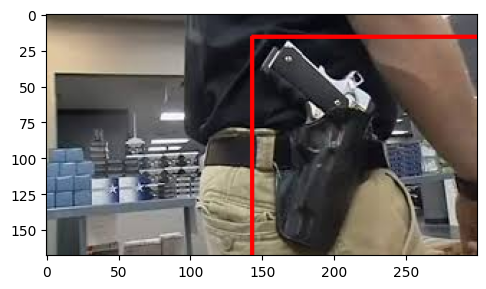

In [21]:
plot_img_bbox(torch_to_pil(img), ground)

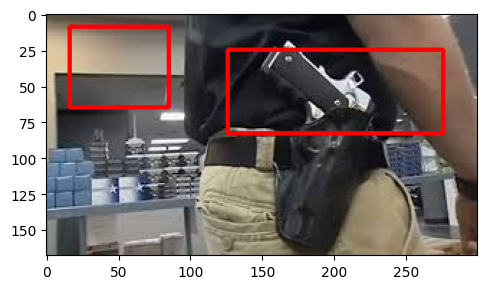

In [22]:
plot_img_bbox(torch_to_pil(img), nms_prediction)